Step 1:

Explanation: The code starts by importing necessary libraries for data manipulation, visualization, and machine learning. It then loads three datasets: a sample submission file (for Kaggle competition format), a test dataset, and a training dataset.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform

# Load datasets (LOCAL)
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
sub_df = pd.read_csv("data/sample_submission.csv")

print("train:", train_df.shape)
print("test:", test_df.shape)
print("sample_submission:", sub_df.shape)

train_df.head()


train: (1000, 31)
test: (253, 30)
sample_submission: (253, 2)


,id,num_recipients,school,school_type,state,zip_code,avg_disbursed_loan,zip_median_household_income,degree_length,room_and_board_price,...,non_resident_foreign_enrolled,total_minority_enrolled,two_or_more_races_enrolled,unknown_enrolled,white_enrolled,women_enrolled,county_name,county_labor_force,county_employed,county_unemployed
0,1,403,BROOKHAVEN COLLEGE,PUBLIC,TX,75244,1796.140930,70308,2 Year,NaN,...,54,8212,157,448,3689,7239,Dallas,1195683,1092540,103143
1,2,204,COLLEGE OF COURT REPORTING,PROPRIETARY,IN,46342,2533.485564,54740,2 Year,NaN,...,0,46,0,16,156,202,Lake,229122,205072,24050
2,3,3122,MILWAUKEE AREA TECHNICAL COLLEGE,PUBLIC,WI,53233,1901.387567,13905,2 Year,NaN,...,0,8478,459,1147,7087,9382,Milwaukee,476599,429808,46791
3,4,234,MCHENRY COUNTY COLLEGE,PUBLIC,IL,60012,1548.753425,103390,2 Year,NaN,...,12,1548,126,463,4544,3534,McHenry,168589,150630,17959
4,5,61,OZARK CHRISTIAN COLLEGE,PRIVATE,MO,64801,2206.133820,36578,4 Year,6160.0,...,12,75,29,1,645,336,Jasper,58771,53830,4941


In [2]:
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

# Corrected variable name from 'dtest' to 'test_df'
for col in test_df.select_dtypes(include=["object"]).columns:
    test_df[col].fillna(test_df[col].mode()[0], inplace=True)

# More robust data loading and cleaning (second approach)

# Convert numeric columns properly
train_df = train_df.apply(pd.to_numeric, errors='coerce')
test_df = test_df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with median
train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

/var/folders/lm/bwb26kh5161gnv6j5vx6p81c0000gn/T/ipykernel_1693/3936192057.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[col].fillna(test_df[col].mode()[0], inplace=True)


In [7]:
# Alias to match the rest of the notebook
dtrain = train_df.copy()


Step 3:
Explanation: This section visualizes the data to understand the relationships between variables. It creates scatter plots to see how average disbursed loans vary by school and school type, boxplots to compare loan distributions across school types, and calculates summary statistics for each school type. A histogram also shows the overall distribution of loan amounts.

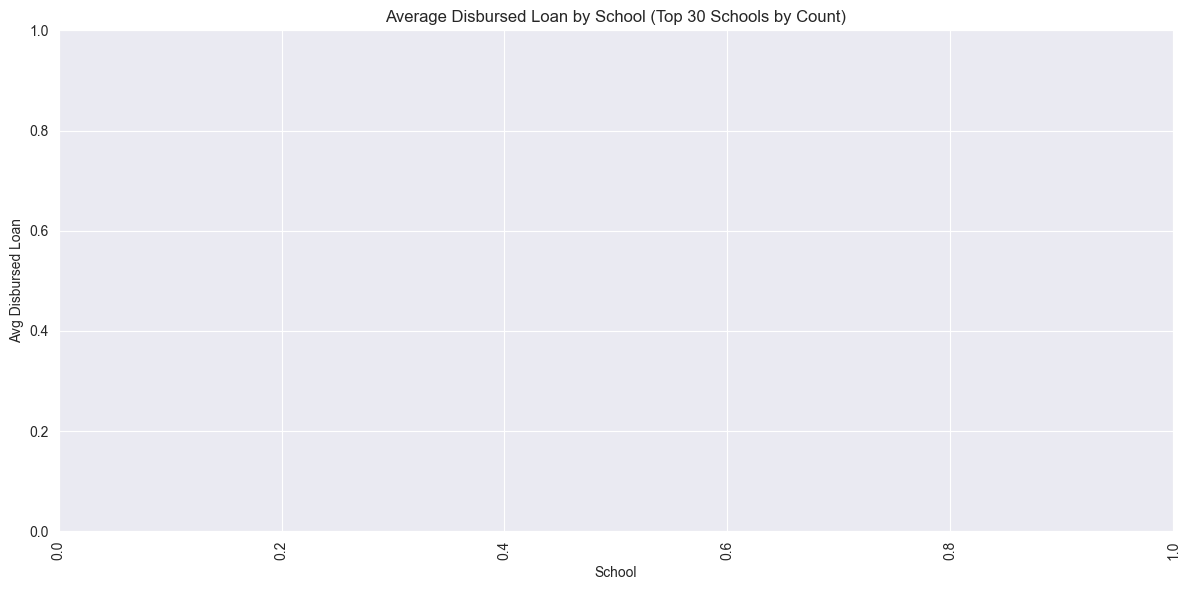

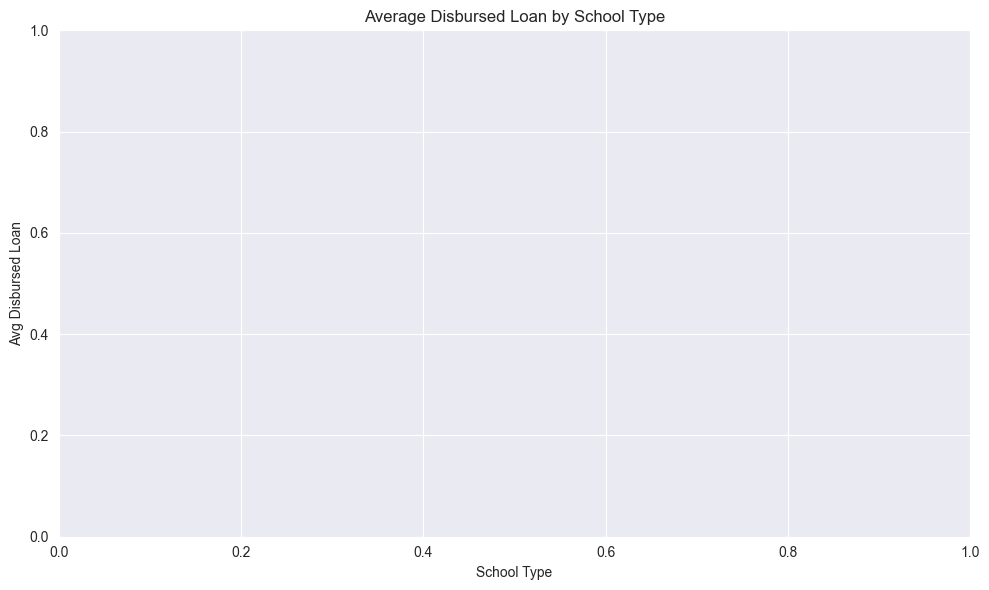

Summary Statistics by School Type:
 Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


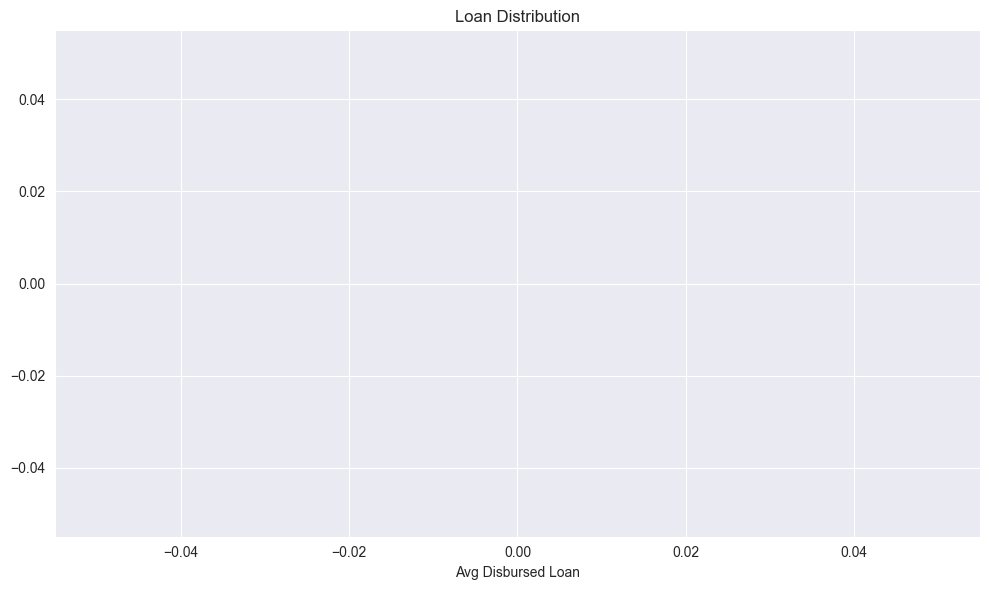

In [9]:
# Clean plotting frame (drop rows missing any needed fields)
plot_df = dtrain[["school", "school_type", "avg_disbursed_loan"]].dropna()

# (Optional) If you have too many schools, show only top N by count
top_n = 30
top_schools = plot_df["school"].value_counts().head(top_n).index
plot_df_top = plot_df[plot_df["school"].isin(top_schools)].copy()

# Scatter plot: Avg disbursed loan by school (Top N schools)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=plot_df_top,
    x="school",
    y="avg_disbursed_loan",
    hue="school_type",
    alpha=0.7
)
plt.title(f"Average Disbursed Loan by School (Top {top_n} Schools by Count)")
plt.xlabel("School")
plt.ylabel("Avg Disbursed Loan")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Boxplot: Avg disbursed loan by school type
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=plot_df,
    x="school_type",
    y="avg_disbursed_loan"
)
plt.title("Average Disbursed Loan by School Type")
plt.xlabel("School Type")
plt.ylabel("Avg Disbursed Loan")
plt.tight_layout()
plt.show()

# Summary statistics for avg disbursed loan by school type
summary_stats = plot_df.groupby("school_type")["avg_disbursed_loan"].describe()
print("Summary Statistics by School Type:\n", summary_stats)

# Histogram of loan distribution
plt.figure(figsize=(10, 6))
sns.histplot(plot_df["avg_disbursed_loan"], bins=30, kde=True)
plt.title("Loan Distribution")
plt.xlabel("Avg Disbursed Loan")
plt.tight_layout()
plt.show()


Step 4: Feature Engineering

Explanation: This function creates new features from existing ones to potentially improve the model's performance. It creates combinations of tuition and career pay estimates, calculates the ratio of tuition to household income, and combines room/board price with enrollment. The code then prepares the feature matrix (X) and target variable (y) for model training.


In [10]:
def engineer_features(df):
    # Ensure these columns are numeric before operations
    numeric_cols = ["in_state_tuition", "early_career_pay_estimate", "mid_career_pay_estimate",
                    "zip_median_household_income", "room_and_board_price", "total_enrollment"]
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float

    # Feature Engineering (Only if columns exist)
    if all(col in df.columns for col in ["in_state_tuition", "early_career_pay_estimate"]):
        df["tuition_earlyCareer"] = df["in_state_tuition"] * df["early_career_pay_estimate"]
    if all(col in df.columns for col in ["in_state_tuition", "mid_career_pay_estimate"]):
        df["tuition_midCareer"] = df["in_state_tuition"] * df["mid_career_pay_estimate"]
    if all(col in df.columns for col in ["in_state_tuition", "zip_median_household_income"]):
        df["tuition_income_ratio"] = df["in_state_tuition"] / (df["zip_median_household_income"] + 1)
    if all(col in df.columns for col in ["room_and_board_price", "total_enrollment"]):
        df["room_board_enrollment"] = df["room_and_board_price"] * df["total_enrollment"]
    
    return df

# Create X, y from train_df
X = train_df.drop(["avg_disbursed_loan", "id"], axis=1, errors="ignore")
y = train_df["avg_disbursed_loan"].values

# Engineer features for train and test sets
X = engineer_features(X)
X_test = test_df.drop(["id"], axis=1, errors="ignore")
X_test = engineer_features(X_test)

Step 5: Model Training and Hyperparameter Tuning


Explanation: This segment splits the data into training and validation sets, creates a custom RMSE (Root Mean Squared Error) scoring function, and performs hyperparameter tuning for an XGBoost regression model using RandomizedSearchCV. The hyperparameter search explores different tree depths, learning rates, and sampling strategies to find the best combination.


In [14]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Critical fix: Reset indexes after split
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_val = pd.Series(y_val).reset_index(drop=True)

# RMSE Scorer
def rmse_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_metric, greater_is_better=False)

# XGBoost + Randomized Search
xgb_model = XGBRegressor(random_state=42, tree_method="hist")

param_distributions = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 7),
    "learning_rate": uniform(0.05, 0.15),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3)
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring=rmse_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

fit_params = {
    "eval_set": [(X_val, y_val)],
    "early_stopping_rounds": 30,
    "verbose": False
}

random_search.fit(X_train, y_train)

print("\nBest Params:", random_search.best_params_)
best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Params: {'colsample_bytree': np.float64(0.935552788417904), 'learning_rate': np.float64(0.07995106732375395), 'max_depth': 5, 'n_estimators': 163, 'subsample': np.float64(0.8400288679743939)}


Step 6:Model Eval

Explanation: The best XGBoost model from the hyperparameter search is evaluated on the validation set. Two metrics are reported: RMSE (lower is better) and R² (higher is better). RMSE measures the average prediction error in the original units, while R² indicates the proportion of variance explained by the model.

In [15]:
# Validation
y_val_pred = best_xgb.predict(X_val) #random search funtion from XGB
#20% of original data for DatathonProjectFolder

val_rmse = rmse_metric(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"\nValidation RMSE: {val_rmse:.3f}")
print(f"Validation R^2: {val_r2:.3f}")


Validation RMSE: 1020.602
Validation R^2: 0.547


Step 7: Feature Analysis

Explanation: This section analyzes the importance of each feature in the trained XGBoost model. Features with very low importance (< 0.0001) are identified and optionally removed from the dataset to simplify the model.


In [16]:
# Feature importances
importances = best_xgb.feature_importances_
imp_series = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("\nTop 20 Features by Importance:")
print(imp_series.head(20))

#best_xgb.feature_importances_ retrieves the importance scores
#of each feature.
#These scores indicate how much each feature contributes 
#to the model’s predictions.
#Higher values = more important features; lower values = less useful features.



# Optional: drop low-importance features
low_importance = imp_series[imp_series < 1e-4].index
if len(low_importance) > 0:
    print("\nDropping these near-zero-importance features:", list(low_importance))
    X_train = X_train.drop(columns=low_importance, errors="ignore")
    X_val = X_val.drop(columns=low_importance, errors="ignore")
    X_test = X_test.drop(columns=low_importance, errors="ignore")


Top 20 Features by Importance:
room_and_board_price                         0.113895
mid_career_pay_estimate                      0.107284
out_of_state_tuition                         0.105025
early_career_pay_estimate                    0.072389
num_recipients                               0.054977
total_enrollment                             0.052872
tuition_midCareer                            0.050765
non_resident_foreign_enrolled                0.040196
room_board_enrollment                        0.034159
tuition_earlyCareer                          0.030102
in_state_tuition                             0.029648
asian_enrolled                               0.028404
tuition_income_ratio                         0.027370
american_indian_alaska_native_enrolled       0.024659
unknown_enrolled                             0.023353
total_minority_enrolled                      0.022120
women_enrolled                               0.021170
native_hawaiian_pacific_islander_enrolled    0.018

Step 8: Final Model Training and Prediction

Explanation: This final section combines the training and validation sets to train the model on all available data. It also creates an ensemble model by averaging predictions from XGBoost and Random Forest models, which often yields better performance than either model alone. The ensemble is evaluated on the validation set, and then used to generate predictions for the test set. Finally, a submission file is created for the Kaggle competition.


In [18]:

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_combined = pd.concat([X_train, X_val], ignore_index=True)
y_combined = pd.concat([y_train, y_val], ignore_index=True)


best_xgb.fit(X_combined, y_combined)

# Optional ensemble
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_combined, y_combined)


y_val_pred_xgb = best_xgb.predict(X_val)
y_val_pred_rf = rf.predict(X_val)
y_val_pred_ensemble = 0.5 * y_val_pred_xgb + 0.5 * y_val_pred_rf

ensemble_rmse = rmse_metric(y_val, y_val_pred_ensemble)
ensemble_r2 = r2_score(y_val, y_val_pred_ensemble)

print(f"\nEnsemble RMSE: {ensemble_rmse:.3f}")
print(f"Ensemble R^2: {ensemble_r2:.3f}")


y_test_pred_xgb = best_xgb.predict(X_test)
y_test_pred_rf = rf.predict(X_test)
y_test_pred_ensemble = 0.5 * y_test_pred_xgb + 0.5 * y_test_pred_rf

submission = pd.DataFrame({
    "id": test_df["id"],
    "avg_disbursed_loan": y_test_pred_ensemble
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
print(submission.head())



Ensemble RMSE: 268.464
Ensemble R^2: 0.969
Saved submission.csv
     id  avg_disbursed_loan
0  1001         3736.053553
1  1002         2457.803745
2  1003         1771.977042
3  1004         4090.960889
4  1005         4714.913736
